In [1]:
from typing import Sequence, Tuple, Union, Optional, Callable, Literal, Protocol
from jaxtyping import Array, ArrayLike, Float, Int, PyTree, PRNGKeyArray, ScalarLike


import jax
from jax import grad, jit, vmap
import jax.numpy as jnp
from jax import random as jrandom
import equinox as eqx

import optax


from functools import partial

from collections.abc import Generator
from typing_extensions import TypeAlias



from dataclasses import dataclass, asdict, astuple


import matplotlib.pyplot as plt

print(jax.devices())


[CpuDevice(id=0)]


# Utils

In [2]:
class Range(eqx.Module):
    minval: float = 0.0
    maxval: float = 1.0



class MakeScalar(eqx.Module):
    model: eqx.Module

    def __call__(self, *args, **kwargs):
        out = self.model(*args, **kwargs)
        return jnp.reshape(out, ())
    


def plot_3d_differential_data(init_spots, init_vols, differential_data, label):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(init_spots, init_vols, differential_data, c=differential_data, cmap=plt.cm.viridis)
    
    # Add a colorbar to show the mapping of colors to z-values
    cbar = fig.colorbar(sc)
    cbar.set_label(label)
    
    ax.set_title(label)
    ax.set_xlabel("$S_0$")
    ax.set_ylabel("$v_0$")
    ax.set_zlabel(label)
    return fig


def mse(y_pred, y_true):
    return jnp.mean((y_pred - y_true)**2)

def rmse(y_pred, y_true):
    return jnp.sqrt(mse(y_pred, y_true))

def normalize(x, x_mean, x_std):
    return (x - x_mean) / x_std


# HVP stuff from Bachelier

In [3]:

# HVP for single point and single direction from Bachelier
def hvp(f, x, v):
    return jax.jvp(lambda x_: eqx.filter_grad(f)(x_), (x,), (v,))[1]

# from bachelier
def hvp_batch(f, inputs, directions):
    """
    Compute Hessian-vector products: H(x_i) @ v_j
    Args:
        f: scalar-valued function f: R^n -> R
        inputs: [num_inputs, input_dim]
        directions: [num_directions, input_dim]
    Returns:
        hvps: [num_inputs, num_directions, input_dim]
    """
    def hvp_fn(x, v):
        return hvp(f, x, v)
    batched = eqx.filter_vmap(eqx.filter_vmap(hvp_fn, in_axes=(0, None)), in_axes=(None, 0))
    return jnp.transpose(batched(inputs, directions), (1, 0, 2))




# Heston

In [4]:
from typing import Final

    
class Heston(eqx.Module):

    
    # for basket
    basket_dim: Final[int]
    basket_weights: Float[Array, "basket_dim"]


    spot_range:Range = Range(50.0, 150.0)
    vol_range: Range = Range(0.01, 0.1)

    mc_time_steps: int = 1024 # number of time steps for the Monte Carlo simulation
     
    K: float = 100.0        # Strike price
    r: float = 0.05         # Risk-free rate
    T: float = 5.0          # n years until expiry, i.e. T2 - T1
    rho: float = -0.3       # Correlation of asset and volatility
    kappa: float = 2.00     # Mean-reversion rate
    theta: float = 0.09     # Long run average volatility
    xi: float = 1.00        # Volatility of volatility


    # for semi-closed-form solution
    num_w: int = 512
    w_max: float = 100.0

    
    


    def closed_form_price(self, S0, v0):
        """
        Compute the Heston model European call price using the semi-closed-form solution using numerical integration in JAX.

        Math from:  https://www.ma.imperial.ac.uk/~ajacquie/IC_Num_Methods/IC_Num_Methods_Docs/Literature/Heston.pdf
        and form:   https://xilinx.github.io/Vitis_Libraries/quantitative_finance/2019.2/methods/cf-ht.html#chrso2014
        
        Parameters:
        - S0: initial spot price
        - v0: initial variance
       
        Returns:
        - call option price under Heston model
        """

        sigma = self.xi # volatility of volatility

        # integration grid
        w = jnp.linspace(0.0, self.w_max, self.num_w)[1:]  # avoid w=0

        # Heston characteristic function components
        a = self.kappa * self.theta
        def C_D(wi):
            alpha = -0.5 * wi**2 - 0.5j * wi
            beta  = alpha - 1j * self.rho * sigma * wi
            gamma = 0.5 * sigma**2

            h = jnp.sqrt(beta**2 - 4 * alpha * gamma)
            rp = (beta + h) / (sigma**2)
            rm = (beta - h) / (sigma**2)
            g = rm / rp

            exp_neg_ht = jnp.exp(-h * self.T)
            C = a * (rm * self.T - (2.0 / sigma**2) * jnp.log((1 - g * exp_neg_ht) / (1 - g)))
            D = rm * (1 - exp_neg_ht) / (1 - g * exp_neg_ht)
            return C, D

        # vectorize C and D over w
        C_vec, D_vec = jax.vmap(C_D)(w)

        # characteristic function Psi
        log_term = jnp.log(S0) + self.r * self.T
        def Psi(wi, Ci, Di):
            return jnp.exp(Ci * self.theta + Di * v0 + 1j * wi * log_term)

        Psi_w      = Psi(w,      C_vec, D_vec)
        Psi_w_minus_i = Psi(w - 1j, *jax.vmap(C_D)(w - 1j))
        Psi_minus_i = Psi(-1j, *C_D(-1j))

        # integrands for Pi1 and Pi2
        integrand1 = jnp.real(jnp.exp(-1j * w * jnp.log(self.K)) * Psi_w_minus_i / (1j * w * Psi_minus_i))
        integrand2 = jnp.real(jnp.exp(-1j * w * jnp.log(self.K)) * Psi_w      / (1j * w))

        # numerical integration via the trapezoidal rule
        Pi1 = 0.5 + (1.0 / jnp.pi) * jnp.trapezoid(integrand1, w)
        Pi2 = 0.5 + (1.0 / jnp.pi) * jnp.trapezoid(integrand2, w)

        # final price
        price = S0 * Pi1 - jnp.exp(-self.r * self.T) * self.K * Pi2
        return price
    

    def closed_form_basket_price(self, basket_S0s, basket_v0s):
        # vectorize single‐asset pricer over the basket axis
        prices = jax.vmap(self.closed_form_price)(basket_S0s, basket_v0s)
        return jnp.dot(self.basket_weights, prices)
    

    def closed_form_basket_price_x(self, x_flat):
        d = self.basket_dim
        S0s = x_flat[:d]        # first n_dims entries
        v0s = x_flat[d:]        # next n_dims entries
        return self.closed_form_basket_price(S0s, v0s)




    
    #def hessian_2x2_for_basket(self, S0s, v0s):
    #    
    #    
    #    hvps = hvp_batch(
    #        f=self.closed_form_basket_price_x,
    #        # NOTE this is where later the extra basket dim can be added
    #        inputs=jnp.array([(initial_spots, initial_vols)]), 
    #        directions=jnp.array([[1.0, 0.0], [0.0, 1.0]]) 
    #    )
    #    
    #    H_block = jnp.transpose(hvps[0], (1,0))
    #
    #    return H_block




    def sample_data_closed_form(self, key, n_samples=256, is_test=False):    
        
        key, subkey = jrandom.split(key)
        
        minvals=jnp.array([self.spot_range.minval, self.vol_range.minval])
        maxvals=jnp.array([self.spot_range.maxval, self.vol_range.maxval])
        
        initial_states = jrandom.uniform(
            subkey, 
            shape=(n_samples, self.basket_dim, 2), 
            minval=minvals, 
            maxval=maxvals
        ) # (batch, n_dims, 2)
        S0s = initial_states[..., 0]    # (batch, n_dims)
        v0s = initial_states[..., 1]     # (batch, n_dims)
    



        value_and_grad_fn = jax.value_and_grad(self.closed_form_basket_price, argnums=(0,1))
        y, (dS0s, dV0s) = jax.vmap(value_and_grad_fn)(S0s, v0s)
        dydx = jnp.stack([dS0s, dV0s], axis=-1)
        # x:     (batch, n_dims, 2)
        # y:     (batch,)
        # dydx:  (batch, n_dims, 2)
        #print("x shape: ", initial_states.shape)
        #print("y shape: ", y.shape)
        #print("dydx shape: ", dydx.shape)

        
        


        ## Normalize the data
        # TODO make this work
        x_mean = jnp.mean(initial_states, axis=0)   # (basket, 2)
        x_std = jnp.std(initial_states, axis=0)     # (basket, 2)
        y_mean = jnp.mean(y)                        # scalar
        y_std = jnp.std(y)                          # scalar        
        x_normalized = normalize(initial_states, x_mean, x_std)
        y_normalized = normalize(y, y_mean, y_std)
        dydx_normalized = dydx * (x_std / y_std)[None, ...]

        norm_values = {
            "x_mean": x_mean,
            "x_std": x_std,
            "y_mean": y_mean,
            "y_std": y_std,
        }

    
        ## flatten before returning    
        x_flat = initial_states.reshape(initial_states.shape[0], -1)
        dydx_flat = dydx.reshape(dydx.shape[0], -1)
        x_normalized_flat = x_normalized.reshape(x_normalized.shape[0], -1)
        x_raw_flat = initial_states.reshape(initial_states.shape[0], -1)
        dydx_normalized_flat = dydx_normalized.reshape(dydx_normalized.shape[0], -1)

        if not is_test:
            #return x_flat, y, dydx_flat, None
            return x_normalized_flat, y_normalized, dydx_normalized_flat, norm_values



        if is_test:
            # use jax.hessian to compute the second derivatives
            
            x_flat = initial_states.reshape(n_samples, 2*self.basket_dim)

            H_full = jax.vmap(jax.hessian(self.closed_form_basket_price_x))(x_flat)

            H_blocks = H_full.reshape(
                n_samples,
                self.basket_dim, 2,
                self.basket_dim, 2
            ) # (batch, basket, 2 basket, 2)

            # TODO when calculating 2nd order loss with basket size >1 we
            # do actually need the full Hessian returned. Then diag only for visualization?
            #print("H_blocks shape", H_blocks.shape)


            ## only care about diagonal asset‐blocks (i=j)
            #H_diag = jnp.stack([H_blocks[:, i, :, i, :] for i in range(self.basket_dim)], axis=1)  # -> (batch, basket_dim, 2, 2)
            #ddyddx = H_diag
            ##print("ddyddx shape: ", ddyddx.shape)
            ## normalizing the data
            #scale = (x_std[:, :, None] * x_std[:, None, :]) / y_std  
            ## (basket_dim, 2, 2)
            ## add a batch‐axis
            #scale = scale[None, ...]  
            ##(1, basket_dim, 2, 2)
            #ddyddx_normalized =  ddyddx * scale
            
            scale_full = (x_std[:, :, None, None] * x_std[None, None, :, :]) / y_std
            # scale_full: (n, 2, n, 2)

            # 4) broadcast and apply
            H_blocks_norm = H_blocks * scale_full[None, ...]
            # H_blocks_norm: (batch, n, 2, n, 2)
            #norm_values["H_scale_full"] = scale_full
            ddyddx_normalized = H_blocks_norm


            
            #return x_flat, y, dydx_flat, ddyddx, None
            return x_normalized_flat, y_normalized, dydx_normalized_flat, ddyddx_normalized, norm_values




        # For plotting 2nd order HVP results
       
        #else:
        #    initial_states_flat = initial_states.reshape(n_samples, 2*self.basket_dim)  # (batch, 2*basket_dim)
        #
        #    k = 3
        #    key, subkey = jrandom.split(key)
        #    rand_directions = jrandom.normal(subkey, shape=(k, self.basket_dim, 2))
        #    directions = rand_directions
        #    #directions = pre_built_directions
        #    directions_flat = directions.reshape(k, 2*self.basket_dim)  # (k, 2*basket_dim)
        #
        #    hvps_flat = hvp_batch(
        #        f=self.closed_form_basket_price_x,
        #        inputs=initial_states_flat, 
        #        directions=directions_flat 
        #    )# (batch_size, k, 2*basket_dim) 
        #
        #    hvps = hvps_flat.reshape(n_samples, k, self.basket_dim, 2) 
        #    # (batch_size, k, basket_dim, 2)
        #
        #    ddyddx = hvps
        #    #print("ddyddx shape: ", ddyddx.shape)


        # NOTE
        # with basket now the shapes are:
        # x: (batch_size, basket_dim, 2)
        # y: (batch_size, )
        # dydx: (batch_size, basket_dim, 2)
        # ddyddx: (batch_size, k_probe_directions, basket_dim, 2, 2)


        #x = initial_states
        #x_flat = x.reshape(x.shape[0], -1)
        #dydx_flat = dydx.reshape(dydx.shape[0], -1)
        #return x_flat, y, dydx_flat, ddyddx


    

test closed form

In [5]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)

basket_dim = 2

ref_model = Heston(
    basket_dim=basket_dim,
    basket_weights=jrandom.uniform(subkey, shape=(basket_dim,), minval=1.0, maxval=10.0),
    #basket_weights = jnp.ones(shape=(basket_dim)), # for testing
    spot_range = Range(50.0, 150.0),
    vol_range = Range(0.01, 0.1),
    mc_time_steps=1024,
    K= 100.0,
    r = 0.00,
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0
)

test closed form

In [6]:
test_set = ref_model.sample_data_closed_form(key, n_samples=1024, is_test=True)
print("test_set shapes:", test_set[0].shape, test_set[1].shape, test_set[2].shape, test_set[3].shape)

test_set shapes: (1024, 4) (1024,) (1024, 4) (1024, 2, 2, 2, 2)


shapes after getting rid of the basket dimension:
x shape:  (1024, 2)
y shape:  (1024,)
dydx shape:  (1024, 2)
ddyddx shape:  (1024, 2, 2)


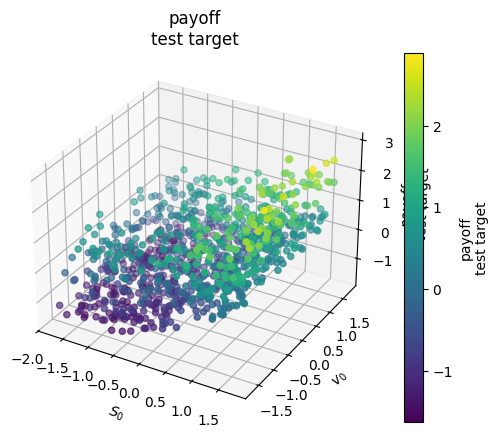

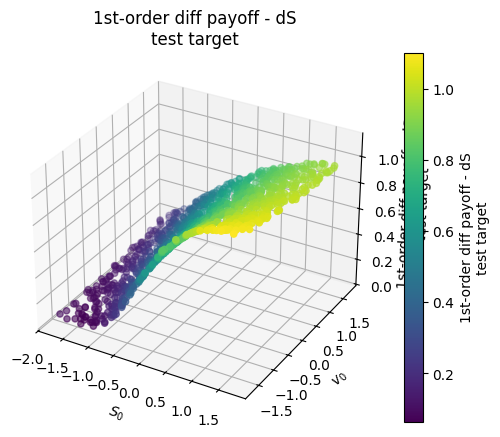

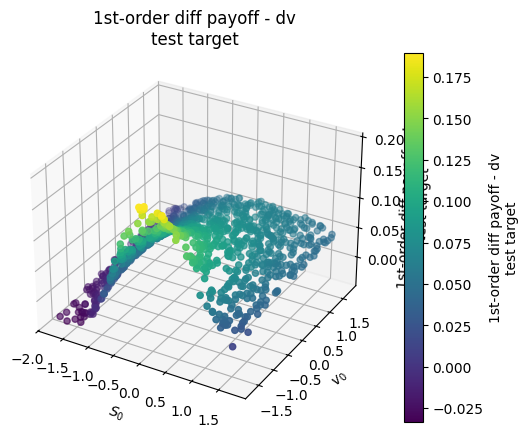

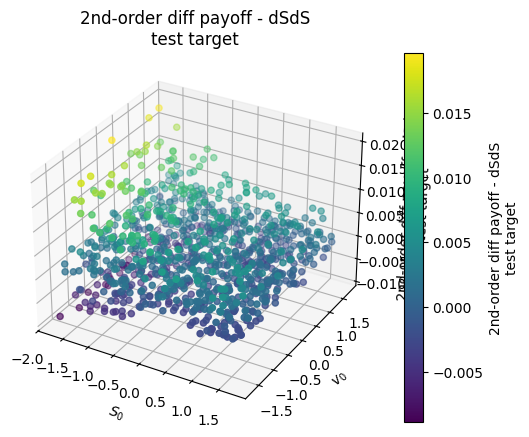

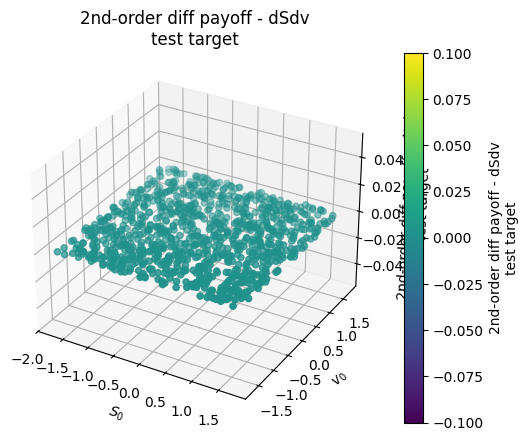

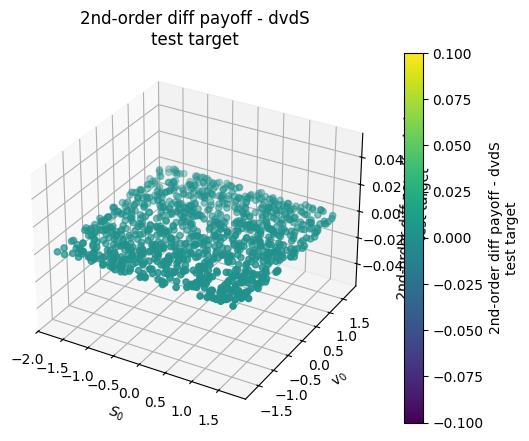

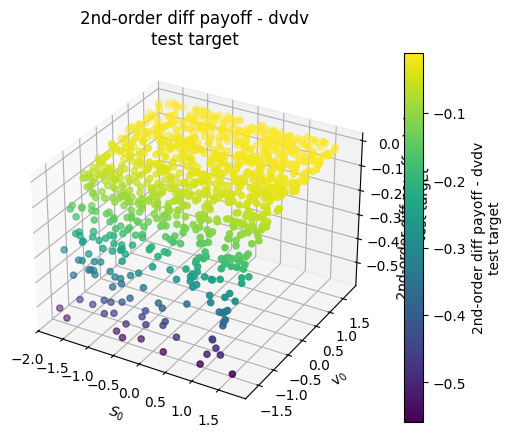

In [7]:
# visulaize the test set
x, y, dydx, ddyddx, _ = test_set

x = x.reshape(x.shape[0], basket_dim, 2)
dydx = dydx.reshape(dydx.shape[0], basket_dim, 2)


# for visualization slice out diagonal blocks of Hessian
ddyddx = jnp.stack([ddyddx[:,i,: ,i,:] for i in range(basket_dim)], axis=1)

# selecting first basket dimension
basket_i = 0

x = x[:, basket_i, :]  # (batch_size, 2)
y = y  # (batch_size, )
dydx = dydx[:, basket_i, :]  # (batch_size, 2)
ddyddx = ddyddx[:, basket_i, :, :]  # (batch_size, k_probe_directions, 2, 2)

## average over the basket dimension
#x = x.mean(axis=1)
#y = y
#dydx = dydx.mean(axis=1) 
#ddyddx = ddyddx.mean(axis=2)

print("shapes after getting rid of the basket dimension:")
print("x shape: ", x.shape)
print("y shape: ", y.shape)
print("dydx shape: ", dydx.shape)
print("ddyddx shape: ", ddyddx.shape)




xs = x[..., 0]
ys = x[..., 1]


fig_payoff = plot_3d_differential_data(xs, ys, y, "payoff\ntest target")

fig_dS = plot_3d_differential_data(xs, ys, dydx[:, 0], "1st-order diff payoff - dS\ntest target")
fig_dv = plot_3d_differential_data(xs, ys, dydx[:, 1], "1st-order diff payoff - dv\ntest target")
#
#
#
#
#num_probes = ddyddx.shape[1]
#for j in range(num_probes):
#    # second‐order effect in the S0‐direction
#    fig_ddS = plot_3d_differential_data(xs, ys, ddyddx[:, j, 0], f"CF 2nd‐order HVP — probe #{j+1} (d²y/dS² direction)\ntrain target")
#    # second‐order effect in the v0‐direction
#    fig_dv = plot_3d_differential_data(xs, ys, ddyddx[:, j, 1], f"CF 2nd‐order HVP — probe #{j+1} (d²y/dv² direction)\ntrain target")



fig_dS = plot_3d_differential_data(xs, ys, ddyddx[:, 0, 0], "2nd-order diff payoff - dSdS\ntest target")
fig_dv = plot_3d_differential_data(xs, ys, ddyddx[:, 0, 1], "2nd-order diff payoff - dSdv\ntest target")
fig_dS = plot_3d_differential_data(xs, ys, ddyddx[:, 1, 0], "2nd-order diff payoff - dvdS\ntest target")
fig_dv = plot_3d_differential_data(xs, ys, ddyddx[:, 1, 1], "2nd-order diff payoff - dvdv\ntest target")



In [8]:

closed_form_vis_batch = ref_model.sample_data_closed_form(key, n_samples=1024)
print("sample batch shapes:", closed_form_vis_batch[0].shape, closed_form_vis_batch[1].shape, closed_form_vis_batch[2].shape)

sample batch shapes: (1024, 4) (1024,) (1024, 4)


shapes after getting rid of the basket dimension:
x shape:  (1024, 2)
y shape:  (1024,)
dydx shape:  (1024, 2)


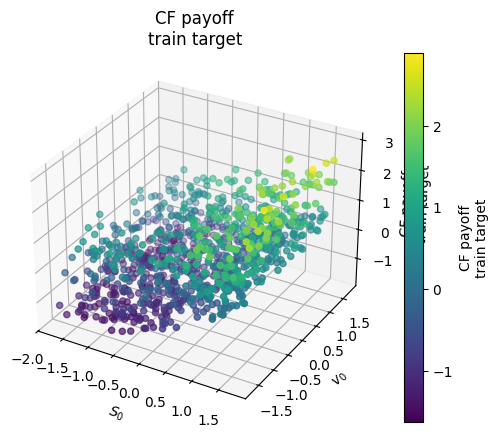

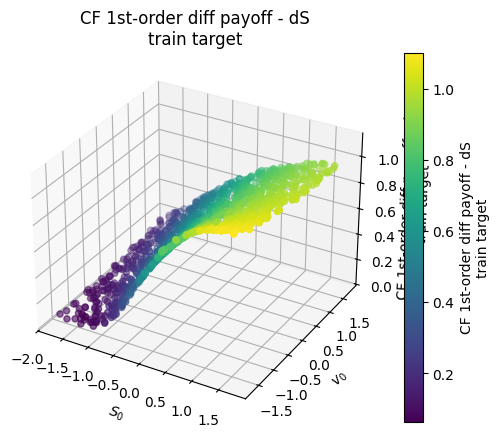

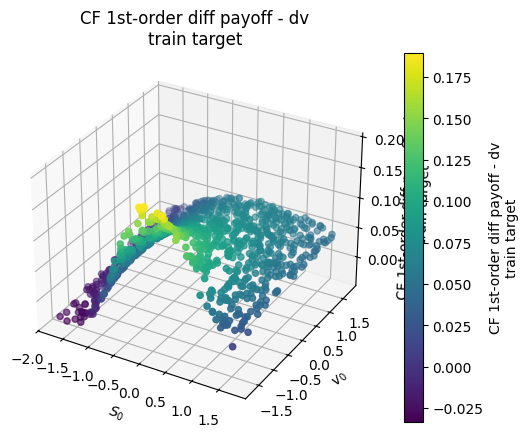

In [9]:

x, y, dydx, _ = closed_form_vis_batch

x = x.reshape(x.shape[0], basket_dim, 2)
dydx = dydx.reshape(dydx.shape[0], basket_dim, 2)

# selecting first basket dimension
x = x[:, 0, :]  # (batch_size, 2)
y = y  # (batch_size, )
dydx = dydx[:, 0, :]  # (batch_size, 2)
#ddyddx = ddyddx[:, :, 0, :]  # (batch_size, k_probe_directions, 2, 2)

## average over the basket dimension
#x = x.mean(axis=1)
#y = y
#dydx = dydx.mean(axis=1) 
#ddyddx = ddyddx.mean(axis=2)

print("shapes after getting rid of the basket dimension:")
print("x shape: ", x.shape)
print("y shape: ", y.shape)
print("dydx shape: ", dydx.shape)
#print("ddyddx shape: ", ddyddx.shape)




xs = x[..., 0]
ys = x[..., 1]


fig_payoff = plot_3d_differential_data(xs, ys, y, "CF payoff\ntrain target")

fig_dS = plot_3d_differential_data(xs, ys, dydx[:, 0], "CF 1st-order diff payoff - dS\ntrain target")
fig_dv = plot_3d_differential_data(xs, ys, dydx[:, 1], "CF 1st-order diff payoff - dv\ntrain target")



#
#num_probes = ddyddx.shape[1]
#for j in range(num_probes):
#    # second‐order effect in the S0‐direction
#    fig_ddS = plot_3d_differential_data(xs, ys, ddyddx[:, j, 0], f"CF 2nd‐order HVP — probe #{j+1} (d²y/dS² direction)\ntrain target")
#    # second‐order effect in the v0‐direction
#    fig_dv = plot_3d_differential_data(xs, ys, ddyddx[:, j, 1], f"CF 2nd‐order HVP — probe #{j+1} (d²y/dv² direction)\ntrain target")



# Learning

### Model

In [10]:
def trunc_init(weight: Array, key: jax.random.PRNGKey) -> Array:
  out, in_ = weight.shape
  stddev = jnp.sqrt(1 / in_)
  return jax.nn.initializers.glorot_normal()(key, (out, in_))

def init_linear_weight(model, init_fn, key):
  is_linear = lambda x: isinstance(x, eqx.nn.Linear)
  get_weights = lambda m: [x.weight
                           for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                           if is_linear(x)]
  weights = get_weights(model)
  new_weights = [init_fn(weight, subkey)
                 for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
  new_model = eqx.tree_at(get_weights, model, new_weights)
  return new_model

### get directions

In [163]:
def get_rand_SVD_directions(f, x, norm_values, k, key, kappa=0.95, normalize=True):

    x_std = norm_values["x_std"]
    
    # TODO first rand svd experimental implementation
    #dim = x.shape[-1]
    #sketch_directions = generate_random_vectors(k, dim, key) # (k, dim)
    
    sketch_directions = jrandom.normal(key, shape=(k, basket_dim, 2))   # (k, basket, 2)
    #jax.debug.print("sd.shape {shape}", shape=sketch_directions.shape)

    # if f = price function, not model
    dirs_scaled = sketch_directions * x_std[None, :, :] # (k, basket, 2)
    #jax.debug.print("scaled.shape {shape}", shape=dirs_scaled.shape)    
    dirs_scaled_flat  = dirs_scaled.reshape(k, 2*basket_dim) # (k, 2*basket)
    #jax.debug.print("flat.shape {shape}", shape=dirs_scaled_flat.shape)
    sketch_directions = dirs_scaled_flat
    


    ## Step 1: build sketch Y = H @ sketch_directions
    #Y = hvp_batch(f=f, inputs=x, directions=sketch_directions) # (batch_size, k, dim)
    ##jax.debug.print("Y.shape {shape}", shape=Y.shape)
    ## TODO understand if averaging over batch_size is the correct approach
    #Y = jnp.mean(Y, axis=0)  # (k, dim)
    #Y = Y.T # (dim, k)
    ##jax.debug.print("Y.shape {shape}", shape=Y.shape)


    Y = hvp_batch(
        f=f,
        inputs=x, 
        directions=sketch_directions
    ) # (batch, k, 2*basket)
    #jax.debug.print("Y.shape {shape}", shape=Y.shape)
    # TODO re-normalize here ????

    Y = jnp.mean(Y, axis=0)  # (k, dim)
    Y = Y.T # (2*basket, k)
    #jax.debug.print("Y.shape {shape}", shape=Y.shape)
    #return sketch_directions.reshape(k, basket_dim, 2), None, None


    ## power iterated version of step 1
    #Y = hvp_power_iterated_sketch(f=f, x=x, sketch_directions=sketch_directions, q=3) # (k, dim)
    #Y = Y.T # (dim, k)
    
    
    
    # Step 2: orthonormalize Y
    # TODO breaks when k > dim, which I guess makes sense
    Q, _ = jnp.linalg.qr(Y) # (*2basket, k)  
    #jax.debug.print("Q.shape {shape}", shape=Q.shape)
    #return sketch_directions.reshape(k, basket_dim, 2), None, None





    ## Step 3: each row of B is H @ q_i
    #B_rows = hvp_batch(f=f, inputs=x, directions=Q.T) # (batch_size, k, dim)
    ##jax.debug.print("B_rows.shape {shape}", shape=B_rows.shape)  
    ## TODO understand if averaging over batch_size is the correct approach
    #B_rows = jnp.mean(B_rows, axis=0) # (k, dim)
    ##jax.debug.print("B_rows.shape {shape}", shape=B_rows.shape)
    #B = jnp.stack(B_rows, axis=0) # (k, dim)
    ##jax.debug.print("B.shape {shape}", shape=B.shape)


    B_rows = hvp_batch(
        f=f,
        inputs=x, 
        directions=Q.T
    ) # (batch, k, 2*basket)
    #jax.debug.print("B_rows.shape {shape}", shape=B_rows.shape)

    B_rows = jnp.mean(B_rows, axis=0)  # (k, 2*basket)
    B = jnp.stack(B_rows, axis=0) # (k, 2*basket)
    #jax.debug.print("B.shape {shape}", shape=B.shape)
    



    # Step 4: SVD on B
    U_tilde, S, Vt = jnp.linalg.svd(B, full_matrices=False) # (k, k)
    #jax.debug.print("U_tilde.shape {shape}", shape=U_tilde.shape)
   


    # Step 5: Lift back U = Q @ U_tilde
    U = Q @ U_tilde  # (2*basket, k)
    U = U.T # (k, 2*basket)
    #jax.debug.print("U.shape {shape}", shape=U.shape)

    # TODO re-normalize here ????

    
    S_var = S**2 / jnp.sum(S**2)
    eval_dir = (~(jnp.cumsum(S_var) > kappa)).at[0].set(True) # make use that at least the first principal component is always actively used
    k_dir = jnp.sum(eval_dir) # number of principal components used
    

    return U.reshape(k, basket_dim, 2), eval_dir, k_dir


### Loss Functions

In [ ]:
def standard_loss_fn(model, batch):
    x = batch[0]
    y = batch[1]
    y_pred = vmap(model)(x)
    return mse(y, y_pred)


@eqx.filter_jit
def second_order_loss_fn(model: eqx.nn.MLP, batch, key, ref_model) -> Float:
    
    #batch = ref_model.sample_data(key, batch_size)
        
    x = batch[0]
    y = batch[1]
    dydx = batch[2]
    norm_values = batch[3]
    

    #print("x shape: ", x.shape)
    #print("y shape: ", y.shape)
    #print("dydx shape: ", dydx.shape)
    #print("ddyddx shape: ", ddyddx.shape)
    #print("")
    #return .0


    # TODO normalization ?
    #x = (x - x_mean) / x_std
    #y = (y - y_mean) / y_std
    
    # TODO loss balancing
    #lam = 1
    #n_dims = model.in_size
    #lambda_scale = lam * n_dims
    #alpha = 1.0/(1.0 + lambda_scale)
    #beta = lambda_scale/(1.0 + lambda_scale)
    #gamma = 0.0

   

    
    
    y_pred, dydx_pred = vmap(eqx.filter_value_and_grad(model))(x)
    assert(y_pred.shape == y.shape)
    assert(dydx_pred.shape == dydx.shape)
    
    #print("y_pred shape: ", y_pred.shape)
    #print("dydx_pred shape: ", dydx_pred.shape)
    #print("")
    #return .0
    
    


    # undo normalization of x for pricing function
    x_mean = norm_values["x_mean"]
    x_std = norm_values["x_std"]
    y_mean = norm_values["y_mean"]
    y_std = norm_values["y_std"]
    x_norm = x.reshape(x.shape[0], basket_dim, 2)                      # (batch, n, 2)                                 # (n, 2)
    x_raw  = x_norm * x_std[None, :, :] + x_mean[None, :, :]      # (batch, n, 2)
    x_raw_flat = x_raw.reshape(x.shape[0], 2*basket_dim)               # (batch, 2*n)
    





    k = 4

    # 2nd order loss in random directions
    key, subkey = jrandom.split(key)
    rand_directions = jrandom.normal(subkey, shape=(k, basket_dim, 2))
    # (k, basket, 2)

    rand_svd_directions, _, _ = get_rand_SVD_directions(
                                    f=ref_model.closed_form_basket_price_x,
                                    #f=MakeScalar(model), 
                                    x=x_raw_flat, 
                                    norm_values=norm_values,
                                    k=k,
                                    key=key
                                    )
    # (k, basket, 2)
    
    
    
    
    #directions = rand_directions
    directions = rand_svd_directions
    
    



    # 2nd order targets via pricing function
    

    
    dirs_scaled = directions * x_std[None, :, :]
    dirs_scaled_flat  = dirs_scaled.reshape(k, 2*basket_dim) 
    
    # get the actual targets
    target_hvps = hvp_batch(
        f=ref_model.closed_form_basket_price_x,
        inputs=x_raw_flat, 
        directions=dirs_scaled_flat
    )

    # re-normalize target_hvps for comparison with model preds
    # TODO thius is ugly af
    hvp = target_hvps.reshape(x.shape[0], k, basket_dim, 2)          # (batch, k, n, 2)
    diag_scale = (x_std**1) / y_std                              # (n, 2)
    hvp_norm = hvp * diag_scale[None, None, :, :]                # (batch, k, n, 2)
    target_hvps = hvp_norm.reshape(x.shape[0], k, 2*basket_dim)





    # (batch_size, k, 2*basket_dim) 
    #print("target_hvps shape:", target_hvps.shape)
    #return .0

    #hvps = hvps_flat.reshape(n_samples, k, self.basket_dim, 2) 
    # (batch_size, k, basket_dim, 2)
    
    # 2nd order preds via model
    pred_hvps = hvp_batch(
        f=MakeScalar(model),
        inputs=x, 
        directions=directions.reshape(k, 2*basket_dim)
    )
    # (batch_size, k, basket_dim*2)
    #print("pred_hvps shape:", pred_hvps.shape)

    #print("target nans:", jnp.isnan(target_hvps).sum())
    #print("pred nans:", jnp.isnan(target_hvps).sum())


    ## Ture Hessians vis jax.hessian for testing
    #model_ddyddx = vmap(jax.hessian(MakeScalar(model)))(x)
    #model_ddyddx = model_ddyddx.reshape(x.shape[0], basket_dim, 2, basket_dim, 2)
    #model_ddyddx_diag = jnp.stack([model_ddyddx[:,i,: ,i,:] for i in range(basket_dim)], axis=1)
    #true_ddyddx = vmap(jax.hessian(ref_model.closed_form_basket_price_x))(x_raw_flat)
    #true_ddyddx_blocks = true_ddyddx.reshape(
    #            x.shape[0],
    #            basket_dim, 2,
    #            basket_dim, 2
    #        )
    #scale_full = (x_std[:, :, None, None] * x_std[None, None, :, :]) / y_std
    #true_ddyddx = true_ddyddx_blocks * scale_full[None, ...]
    #true_ddyddx_diag = jnp.stack([true_ddyddx[:,i,: ,i,:] for i in range(basket_dim)], axis=1)
    #print("target nans:", jnp.isnan(true_ddyddx).sum())
    #print("pred nans:", jnp.isnan(model_ddyddx).sum())




    #ddyddx_pred = vmap(jax.hessian(MakeScalar(model)))(x)
    assert(target_hvps.shape == pred_hvps.shape)
    
    #print("ddyddx_pred shape: ", ddyddx_pred.shape)
    #print("")
    #return .0



    value_loss = mse(y_pred, y)
    grad_loss = mse(dydx_pred, dydx)
    hess_loss = mse(pred_hvps, target_hvps) 
    #hess_loss = mse(model_ddyddx, true_ddyddx)
    #hess_loss = mse(model_ddyddx_diag, true_ddyddx_diag) 

    
    #hess_loss = mse(ddyddx_pred, ddyddx)
    #hess_loss = 0


    #jax.debug.print("value loss: {}", value_loss)
    #jax.debug.print("grad loss: {}", grad_loss)
    #jax.debug.print("hess loss: {}", hess_loss)
    #jax.debug.print("---------------------------------")
    


    #gamma = epoch_percent/20
    #alpha = (1-gamma)/2
    #beta = (1-gamma)/2

    alpha = 1/3
    beta = 1/3
    gamma = 1/3
    #alpha = 0.4
    #beta = 0.4
    #gamma = 0.2
    #alpha = 0.49
    #beta = 0.49
    #gamma = 1 - (alpha + beta)
    
    loss = alpha*value_loss + beta*grad_loss + gamma*hess_loss
    #loss = 0.5*value_loss + 0.5*grad_loss

    return loss




### Train

In [ ]:
from itertools import islice

Data: TypeAlias = dict[str, Float[Array, "n_samples ..."]]
DataGenerator: TypeAlias = Generator[Data, None, None]


def train(
    model: PyTree,
    test_data: Tuple,
    optim: optax.GradientTransformation,
    n_epochs: int,
    n_batches_per_epoch: int,
    batch_size: int,
    key: PRNGKeyArray,
    ref_model,
) -> PyTree:
    

    @eqx.filter_jit
    def train_step(model: PyTree, opt_state: PyTree, batch_size: int, batch_key):
        
        batch = ref_model.sample_data_closed_form(batch_key, batch_size)

        #loss_value, grads = eqx.filter_value_and_grad(standard_loss_fn)(model, batch)
        loss_value, grads = eqx.filter_value_and_grad(second_order_loss_fn)(model, batch, batch_key, ref_model)
        


        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    train_loss = jnp.zeros(1)

    n_steps = n_epochs * n_batches_per_epoch
    print(f"Training for {n_epochs} epochs with {n_batches_per_epoch} batches per epoch and batch size {batch_size}.")
    
    keys = jrandom.split(key, n_steps)

    #epoch_percent = 0
    for i, batch_key in enumerate(keys):
        
        # print(i)
        # print(batch["normalized_initial_states"])
        # print(batch["normalized_payoffs"].shape)
        with jax.profiler.StepTraceAnnotation("Train Step", step_num=i):  

            model, opt_state, train_loss = train_step(model, opt_state, batch_size, batch_key)
        
        if i % n_batches_per_epoch == 0:
            epoch_stats = f"Finished epoch {int(i/n_batches_per_epoch)+1} | Train Loss: {train_loss:.5f}"    

            
            # test data evaluation
            if test_data:
                x_test_flat = test_data[0]#test_data[0].reshape(test_data[0].shape[0], -1)  # flatten the input
                
                
                test_pred_ys, test_pred_dys = vmap(jax.value_and_grad(model))(x_test_flat)
                #test_pred_ddys = vmap(jax.hessian(MakeScalar(model)))(test_set[0])
                y_error = jnp.sqrt(mse(test_pred_ys, test_set[1]))
                #dy_error = jnp.sqrt(mse(test_pred_dys, test_set[2]))
                #ddy_error = jnp.sqrt(mse(test_pred_ddys, test_set[3]))
                test_loss = y_error # (y_error + dy_error + ddy_error) / 3.0
                epoch_stats += f" | Test Value Loss: {test_loss:.5f}"
            
            print(epoch_stats)
        
            
    return model

In [173]:
n_epochs = 100
n_batches_per_epoch = 32
BATCH_SIZE = 256


basket_dim = 2
basket_weights = jrandom.uniform(subkey, shape=(basket_dim,), minval=1.0, maxval=10.0)

# NOTE batch:_size * n_batches_per_epoch = 8192

key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)

ref_model = Heston(
    basket_dim=basket_dim,
    basket_weights=basket_weights,
    spot_range = Range(50.0, 150.0),
    vol_range = Range(0.01, 0.1),
    mc_time_steps=1024,
    K= 100.0,
    r = 0.00,
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0
)

test_set = ref_model.sample_data_closed_form(key, n_samples=1024, is_test=True)

# in_size is 2 for initial_spot and initial_vol
input_dims = 2*basket_dim


key, subkey = jax.random.split(key)
mlp = eqx.nn.MLP(key=subkey, in_size=input_dims, out_size="scalar", width_size=20, depth=3, activation=jax.nn.elu)
mlp = init_linear_weight(mlp, trunc_init, key)
surrogate_model = mlp




# total_steps = 64 * n_epochs
# lr_schedule = optax.exponential_decay(init_value=0.01, transition_steps=total_steps, transition_begin=int(total_steps*0.2), decay_rate=0.9)
# optim = optax.adam(learning_rate=lr_schedule)
optim = optax.adam(learning_rate=1e-3) # 3e-4 was default


surrogate_model = train(
                        model = surrogate_model, 
                        test_data=test_set,
                        optim=optim, 
                        n_epochs=n_epochs,
                        n_batches_per_epoch=n_batches_per_epoch,
                        batch_size=BATCH_SIZE,
                        key=key,
                        ref_model=ref_model
                        )


Training for 100 epochs with 32 batches per epoch and batch size 256.


TypeError: cannot reshape array of shape (4, 4) (size 16) into shape (10, 2, 2) (size 40)

In [170]:
# eval price predictions
test_pred_ys, test_pred_dys = vmap(jax.value_and_grad(surrogate_model))(test_set[0])
test_pred_ddys = vmap(jax.hessian(MakeScalar(surrogate_model)))(test_set[0])
print("Test predictions shapes:")
print("test_pred_ys shape: ", test_pred_ys.shape)
print("test_pred_dys shape: ", test_pred_dys.shape)
print("test_pred_ddys shape: ", test_pred_ddys.shape)

test_pred_ddys = test_pred_ddys.reshape(test_set[0].shape[0], basket_dim, 2, basket_dim, 2)
print("new test_pred_ddys shape: ", test_pred_ddys.shape)
print("")

y_error = jnp.sqrt(mse(test_pred_ys, test_set[1]))
dy_error = jnp.sqrt(mse(test_pred_dys, test_set[2]))
ddy_error = jnp.sqrt(mse(test_pred_ddys, test_set[3]))

print(f"test y error: {y_error:.4f}")
print(f"test dy error: {dy_error:.4f}")
print(f"test ddy error: {ddy_error:.4f}")

Test predictions shapes:
test_pred_ys shape:  (1024,)
test_pred_dys shape:  (1024, 4)
test_pred_ddys shape:  (1024, 4, 4)
new test_pred_ddys shape:  (1024, 2, 2, 2, 2)

test y error: 0.0759
test dy error: 0.0993
test ddy error: 0.1981


In [ ]:
# with normalization        
# with basket size 1 the errors are:

# standard loss fn:
# test y error: 0.0279
# test dy error: 0.0374
# test ddy error: 0.1065


# 1st order loss fn: 0.5*v + 0.5*dv
# test y error: 0.0259   
# test dy error: 0.0221
# test ddy error: 0.0626


# second order loss fn k=10: 0.33*v + 0.33*dv + 0.33*ddv
# test y error: 0.0212
# test dy error: 0.0174
# test ddy error: 0.0392

In [ ]:
# with normalization
# with basket       size 2 

# standard loss fn:
# test y error:     0.0411
# test dy error:    0.0383
# test ddy error:   0.3175


# 1st order loss fn: 0.5*v + 0.5*dv
# test y error:     0.0374 
# test dy error:    0.0292
# test ddy error:   0.3187


# second order loss fn k=10: 0.33*v + 0.33*dv + 0.33*ddv      | rand svd dirs  
# test y error:     0.1702      | 0.0769
# test dy error:    0.2104      | 0.0993
# test ddy error:   0.2152      | 0.1981

shapes after getting rid of the basket dimension:
x shape:  (1024, 2)
y shape:  (1024,)
dydx shape:  (1024, 2)
ddyddx shape:  (1024, 2, 2)


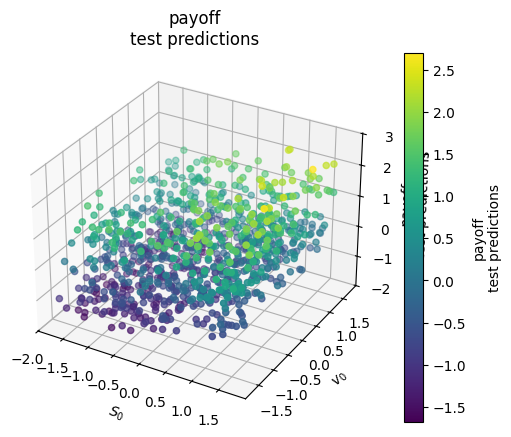

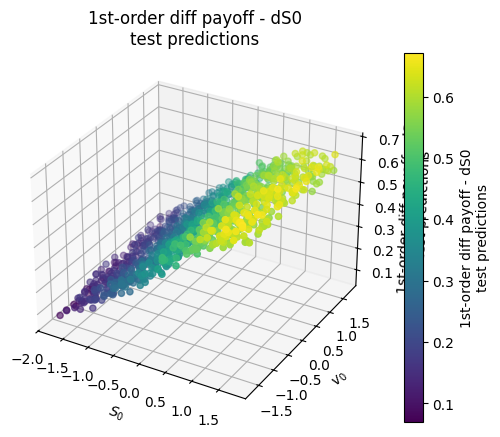

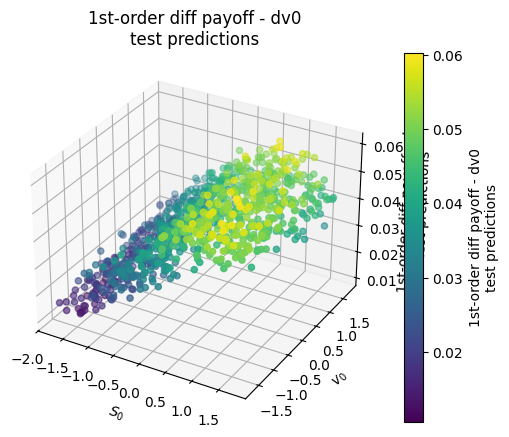

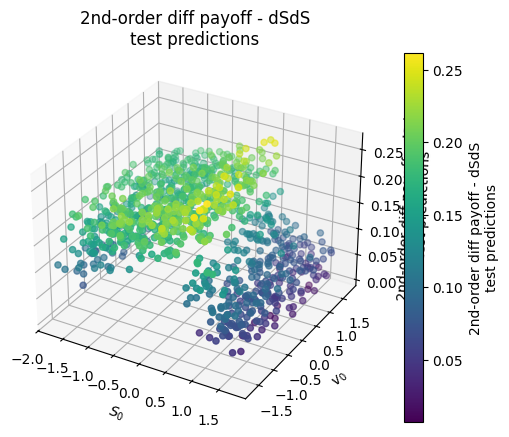

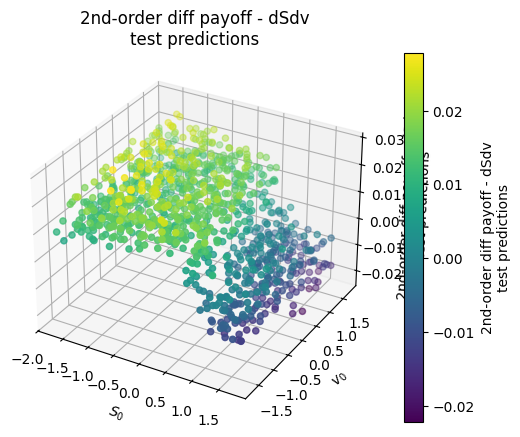

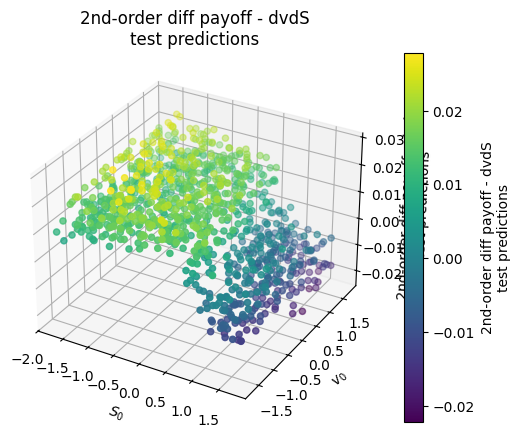

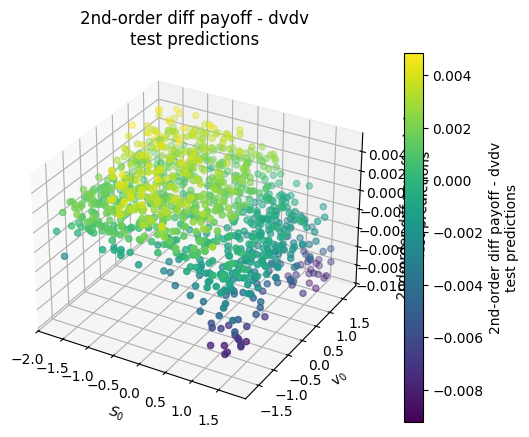

In [171]:
x = test_set[0]
test_size = x.shape[0]

y = test_pred_ys
dydx = test_pred_dys
ddyddx = test_pred_ddys


# for visualization slice out diagonal blocks of Hessian
ddyddx = jnp.stack([ddyddx[:,i,: ,i,:] for i in range(basket_dim)], axis=1)



x = x.reshape(test_size, basket_dim, 2)
dydx = dydx.reshape(test_size, basket_dim, 2)
ddyddx = ddyddx.reshape(test_size, basket_dim, 2, 2)

# selecting first basket dimension
x = x[:, 0, :]  # (batch_size, 2)
y = y  # (batch_size, )
dydx = dydx[:, 0, :]  # (batch_size, 2)
ddyddx = ddyddx[:, 0, :, :]  # (batch_size, k_probe_directions, 2, 2)

print("shapes after getting rid of the basket dimension:")
print("x shape: ", x.shape)
print("y shape: ", y.shape)
print("dydx shape: ", dydx.shape)
print("ddyddx shape: ", ddyddx.shape)




# plot the predictions
xs = x[..., 0]
ys = x[..., 1]



fig_payoff = plot_3d_differential_data(xs, ys, y, "payoff\ntest predictions")



fig_dS = plot_3d_differential_data(xs, ys, dydx[:, 0], "1st-order diff payoff - dS0\ntest predictions")
fig_dv = plot_3d_differential_data(xs, ys, dydx[:, 1], "1st-order diff payoff - dv0\ntest predictions")



fig_dSdS = plot_3d_differential_data(xs, ys, ddyddx[:, 0, 0], "2nd-order diff payoff - dSdS\ntest predictions")
fig_dSdv = plot_3d_differential_data(xs, ys, ddyddx[:, 0, 1], "2nd-order diff payoff - dSdv\ntest predictions")
fig_dvdS = plot_3d_differential_data(xs, ys, ddyddx[:, 1, 0], "2nd-order diff payoff - dvdS\ntest predictions")
fig_dvdv = plot_3d_differential_data(xs, ys, ddyddx[:, 1, 1], "2nd-order diff payoff - dvdv\ntest predictions")

